In [1]:
import torch
from torch import nn, optim
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
from GANmodel import *

In [2]:
"""Training data"""
transform = transforms.Compose([
    transforms.ToTensor(),  # Transform to tensor
    transforms.Normalize((0.5,), (0.5,))
])
data_dir = "./MNIST/"
trainset = torchvision.datasets.MNIST(root=data_dir, train=True, download=False, transform=transform)

batch_size = 100
data_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

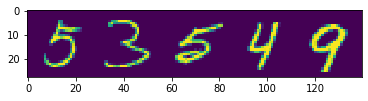

In [3]:
example_data = next(iter(data_loader))[0]
example_data = torch.cat([example_data[i,0,:,:] for i in range(5)],1)
plt.imshow(example_data.detach().numpy())

In [228]:
device='cuda'
nz = 3
netG = Generator(nz=nz, ngf=64, nc=1)
netD = Discriminator(nc=1, ndf=64)

netD = netD.to(device)
netG = netG.to(device)

Epoch 1
0.49736860394477844 0.4958328604698181
0.8024165034294128 0.20332564413547516
0.7480871677398682 0.28361082077026367
0.7677503824234009 0.3099544644355774
0.9571435451507568 0.5176102519035339
0.7873119711875916 0.27106285095214844


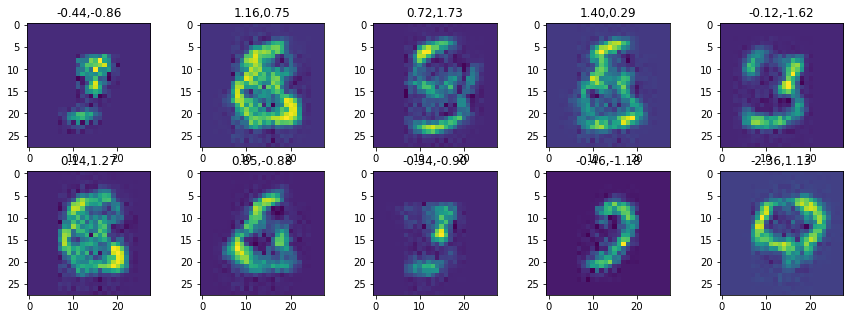

Epoch 2
0.7579315304756165 0.2891545295715332
0.8775638341903687 0.256424218416214
0.9046273827552795 0.33644717931747437
0.9305749535560608 0.3679565489292145
0.850517988204956 0.3148724436759949
0.8845714926719666 0.33277568221092224


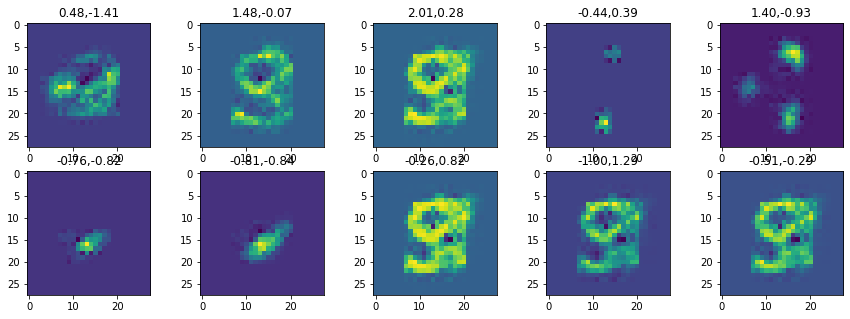

Epoch 3
0.9510455131530762 0.3338782489299774
0.974089503288269 0.3853355348110199
0.9693440198898315 0.3361801505088806
0.9797214865684509 0.35490667819976807
0.9668195843696594 0.3482515215873718
0.9780351519584656 0.3452264964580536


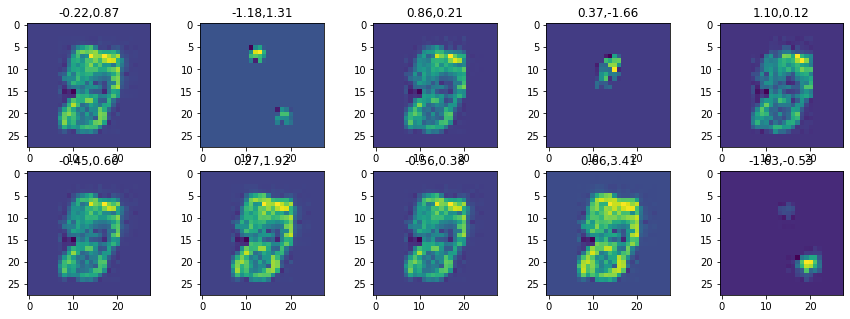

Epoch 4
0.9416548609733582 0.3322797417640686
0.9829016923904419 0.3242570757865906
0.982507050037384 0.309199720621109
0.96677166223526 0.31674522161483765
0.9939404726028442 0.40928885340690613
0.9773468375205994 0.3367867171764374


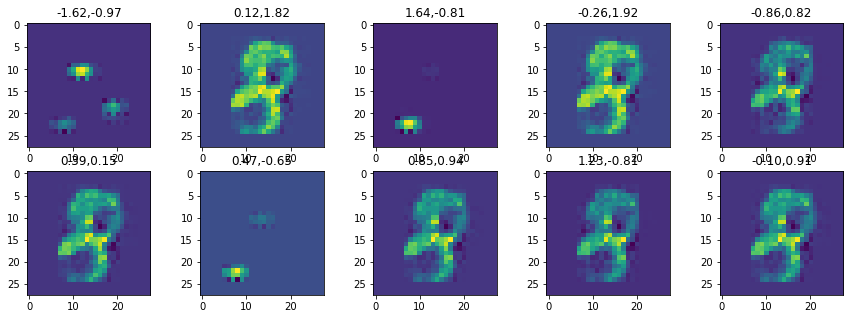

Epoch 5
0.9825366139411926 0.3587833344936371


KeyboardInterrupt: 

In [224]:
optimizer_D = torch.optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5,0.999))
optimizer_G = torch.optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5,0.999))

for epoch in range(20):
    print("Epoch {}".format(epoch + 1))
    
    for idx, (images, labels) in enumerate(data_loader):
        images = images.to(device)
        with torch.no_grad():
            z = torch.randn(images.shape[0], nz, 1, 1, device=device)
            fake_images = netG(z)
        d_loss_real, D_real, d_loss_fake, D_fake = discriminator_loss(netD, images, fake_images)
        optimizer_D.zero_grad()
        d_loss_real.backward()
        d_loss_fake.backward()
        optimizer_D.step()

        z = torch.randn(images.shape[0], nz, 1, 1, device=device)
        fake_images = netG(z)
        loss = generator_loss(netD, fake_images)
        optimizer_G.zero_grad()
        loss.backward()
        optimizer_G.step()

        if idx % 100 == 0:
            print(D_real.item(), D_fake.item())
    
    fig,ax = plt.subplots(2,5, figsize=(15,5))
    with torch.no_grad():
        # Plot generated images
        z = torch.randn(10,nz,1,1).to(device)
        out = netG(z).squeeze().cpu().detach().numpy()
        for i in range(10):
            x = i % 5
            y = i // 5
            ax[y][x].imshow(out[i])
            ax[y][x].set_title("{:.2f},{:.2f}".format(z[i,0,0,0],z[i,1,0,0]))
    plt.show()

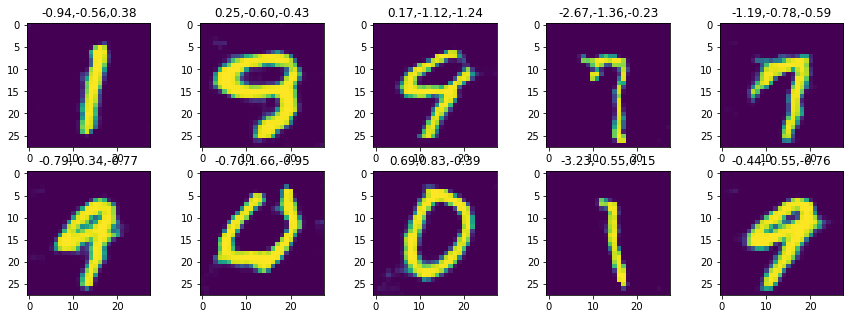

In [230]:
with torch.no_grad():
    z = torch.randn(10,3,1,1).to(device)
    out = netG(z).squeeze().cpu().detach().numpy()
fig,ax = plt.subplots(2,5, figsize=(15,5))
for i in range(10):
    x = i % 5
    y = i // 5
    ax[y][x].imshow(out[i])
    ax[y][x].set_title("{:.2f},{:.2f},{:.2f}".format(z[i,0,0,0],z[i,1,0,0],z[i,2,0,0]))

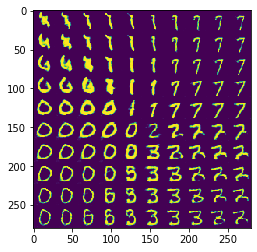

In [215]:
"""Visualize the latent space"""
with torch.no_grad():
    n = 10
    z = torch.cat([torch.linspace(-2.5,2.5,n)[:,None].repeat(n,1), 
                   torch.linspace(2.5,-2.5,n)[:,None].repeat_interleave(n,0),torch.zeros(n**2,1)],1)[:,:,None,None].to(device)
    out = netG(z).squeeze().cpu().detach().numpy()
out_grid = np.zeros((28*n,28*n))
grid_vals = np.linspace(-1,1,n)
for i in range(n**2):
    x = (i % n)
    y = (i // n)
    out_grid[x*28:(x+1)*28,y*28:(y+1)*28] = out[i]
plt.imshow(out_grid)

In [229]:
netG.load_state_dict(torch.load("./GANmodels/3dGenerator"))
netD.load_state_dict(torch.load("./GANmodels/3dDiscriminator"))

<All keys matched successfully>

In [216]:
torch.save(netG.state_dict(), "./GANmodels/3dGenerator")
torch.save(netD.state_dict(), "./GANmodels/3dDiscriminator")

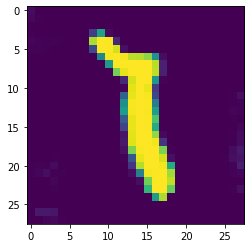

In [171]:
with torch.no_grad():
    z = torch.Tensor([[-0.3,0.1,0.0]])[:,:,None,None].to(device)
    plt.imshow(netG(z).squeeze().cpu().detach().numpy())